In [1]:
from satellite_simulations import get_archival_tles, get_dist_and_sep
from satellite_simulations import enu_to_gps_el, get_time_delays, sinc_beam
from satellite_simulations import pol_beam, brightness_matrix, RIME
from input_rfi import get_corr_idx, avg_redundant_and_reshape
from skyfield.api import load as tle_load
import datetime
import h5py
import healpy as hp
import yaml
from hirax_transfer import HIRAXSurvey
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Get array setup

In [2]:
with open('prod_params.yaml') as f:
    tele = HIRAXSurvey.from_config(yaml.load(f, Loader=yaml.BaseLoader)['telescope'])

In [3]:
n_ants = tele.nfeed/2/len(tele.pointings)

In [4]:
enu = tele.feedpositions[:n_ants,:]
enu = np.concatenate([enu, 1110.*np.ones(len(enu))[:,None]], axis=1)

In [5]:
freqs = tele.frequencies

# Get number of time steps from H5 file

In [3]:
with h5py.File('products/timestream_f/0/timestream.hdf5') as fp:
    time_steps = fp[('timestream')].value

/home/chris/anaconda2/envs/HIRAX/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
time_steps.shape

(16, 401)

# Get the GPS co-ordinates of each antenna using the GPS location of a reference antenna @ ENU = (0, 0, $\cdot$ )

In [8]:
gps_ants = enu_to_gps_el([-30.69, 21.57527778], enu)

# Get the archival TLE files for a specified date range and load them

In [9]:
midnight = datetime.datetime(2019, 6, 28, 0, 0, 0)
one_day = datetime.timedelta(seconds=3600*24)
time_step = datetime.timedelta(seconds=3600*24/time_steps)

In [10]:
tles = tle_load.tle(get_archival_tles(midnight, midnight+one_day))

File 2019-06-28.tle exists and is readable.


# Calculate the distance, and angular separation from pointing direction, between a satellite and each antenna

In [11]:
el, distances, seps = np.array([get_dist_and_sep(tles[tles.keys()[0]], gps, 
                                                        0., midnight) for gps in gps_ants]).T

# Calculate the time delay on each baseline

In [12]:
delays = get_time_delays(distances)

# Set up RFI frequency distribution

In [13]:
RFI_intensity = 1e3
rfi_I = RFI_intensity*np.ones((1, len(freqs)))
rfi_Q = RFI_intensity*np.zeros((1, len(freqs)))
rfi_U = np.zeros((1, len(freqs)))
rfi_V = np.zeros((1, len(freqs)))

# Calculate the visibility samples

In [14]:
E = pol_beam(auto_beam=sinc_beam, cross_beam=None, params=[2., freqs], ang_sep=np.mean(seps, keepdims=True))

In [15]:
B = brightness_matrix(rfi_I, rfi_Q, rfi_U, rfi_V)

In [16]:
V = RIME(B, E, delays[:,None], freqs)

In [17]:
red_V = avg_redundant_and_reshape(tele, V)

In [25]:
red_V.shape

(19, 2)

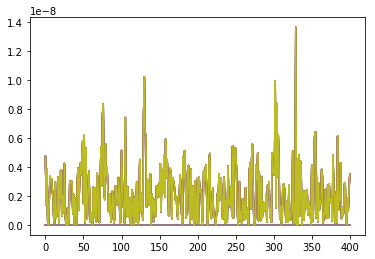

In [53]:
plt.plot(red_V[:,:,0])

In [20]:
def add_rfi_to_H5(path_to_timestream, red_V):
    """
    Add the visibility contribution from RFI into the visibility H5 files.
    
    Parameters:
    -----------
    path_to_timestream: str
        Path to the directory containing each frequency channel.
    red_V: np.array (t_steps,n_bl,n_freqs)
        The visibilities on each unique correlation product.
    """
    
    for i in range(red_V.shape[-1]):
        path = os.path.join(path_to_timestream, str(i))
        with h5py.File(os.path.join(path, 'timestream.hdf5'), 'r+') as fp:
            timestream = fp[('timestream')]
            timestream[...] += red_V[:,3:,i].T
#         with h5py.File(os.path.join(path, 'timestream_rfi.hdf5'), 'w') as fp:
#             fp[('timestream')] = timestream + red_V[:,3:,i].T

In [54]:
def get_rfi_vis_all_time(tele, date, n_time):
    """
    Calculate the visibilities for all time steps.
    
    Parameters:
    ----------
    tele: hirax_transfer.core.HIRAXSurvey
        HIRAX Telescope object.
    date: str
        The date on which to simulate RFI.
    n_time: int
        The number of time steps to simulate.
        
    Return:
    -------
    red_V: np.array (t_steps,n_bl,n_freqs)
        The visibilities 
    """
    
    with open('prod_params.yaml') as f:
        tele = HIRAXSurvey.from_config(yaml.load(f, Loader=yaml.BaseLoader)['telescope'])
    
    n_ants = tele.nfeed/2/len(tele.pointings)
    
    enu = tele.feedpositions[:n_ants,:]
    enu = np.concatenate([enu, 1110.*np.ones(len(enu))[:,None]], axis=1)
    
    freqs = tele.frequencies
    
    gps_ants = enu_to_gps_el([-30.69, 21.57527778], enu)
    
    midnight = datetime.datetime(2019, 6, 28, 0, 0, 0)
    one_day = datetime.timedelta(seconds=3600*24)
    time_step = datetime.timedelta(seconds=3600*24/n_time)
    
    tles = tle_load.tle(get_archival_tles(midnight, midnight+one_day))
    
    red_V = np.zeros((n_time,tele.nbase,len(freqs)), np.complex128)
    
    for i in range(n_time):
        el, distances, seps = np.array([get_dist_and_sep(tles[tles.keys()[0]], gps, 
                                                            0., midnight+time_step*i) for gps in gps_ants]).T
        delays = get_time_delays(distances)
        RFI_intensity = 1e11
        rfi_I = RFI_intensity*np.ones((1, len(freqs)))
        rfi_Q = RFI_intensity*np.zeros((1, len(freqs)))
        rfi_U = np.zeros((1, len(freqs)))
        rfi_V = np.zeros((1, len(freqs)))
    
        E = pol_beam(auto_beam=sinc_beam, cross_beam=None, params=[2., freqs], 
                     ang_sep=np.mean(seps, keepdims=True))
        B = brightness_matrix(rfi_I, rfi_Q, rfi_U, rfi_V)
        V = RIME(B, E, delays[:,None], freqs)
        red_V[i] = avg_redundant_and_reshape(tele, V)
        
    return red_V

In [ ]:
red_V = get_rfi_vis_all_time(tele, ' ', 401)

File 2019-06-28.tle exists and is readable.


In [8]:
red_V.shape

(401, 19, 2)

In [35]:
add_rfi_to_H5('products/timestream_f/', red_V)

In [40]:
with h5py.File('products/timestream_f/0/timestream.hdf5', 'r') as fp:
    ts = fp['timestream'].value

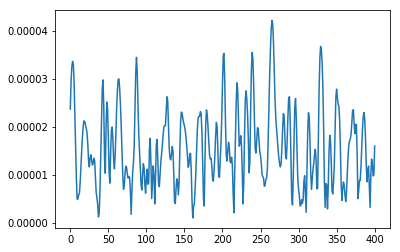

In [49]:
plt.plot(np.abs(ts[0,:]))

In [42]:
nside = 128

mask = np.zeros(hp.nside2npix(nside))
theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
from hirax_transfer.beams import hpang2lonlat
_, lat = hpang2lonlat(np.transpose([theta, phi]))
mask[(lat > -35) & (lat < -25)] = 1.
mask = hp.smoothing(mask, np.radians(5))
mask[(lat < -40) | (lat > -20)] = 0.

Sigma is 127.398270 arcmin (0.037059 rad) 
-> fwhm is 300.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


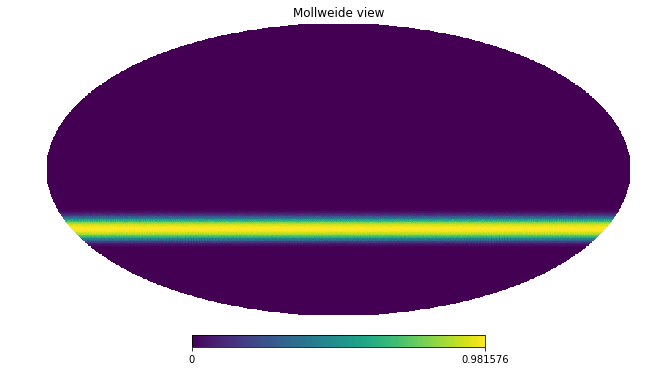

In [44]:
hp.mollview(mask)

In [36]:
with h5py.File('products/map_full.hdf5', 'r') as fp:
    rfi = fp[('map')].value

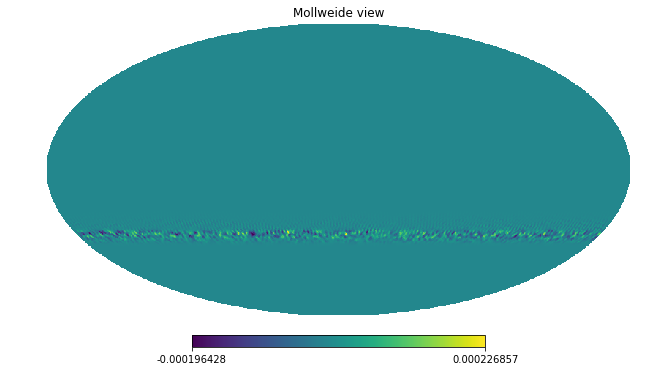

In [46]:
hp.mollview(rfi[0,0,:]*mask)

In [38]:
with h5py.File('old_products/products/map_full.hdf5', 'r') as fp:
    sky = fp[('map')].value

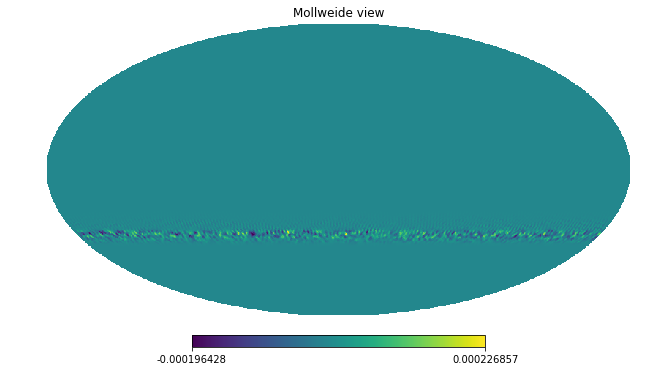

In [47]:
hp.mollview(sky[0,0,:]*mask)